In [58]:
import os

import torch
import numpy as np
import matplotlib.pyplot as plt

import mmcv
from matplotlib.ticker import MultipleLocator
from mmcv import Config
from mmcv.ops import nms
from mmdet.core.evaluation.bbox_overlaps import bbox_overlaps
from mmcv.runner import (get_dist_info, load_checkpoint,
                         wrap_fp16_model)
from mmdet.apis import single_gpu_test
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector
from mmdet.utils import (build_dp, compat_cfg, get_device,
                         replace_cfg_vals, setup_multi_processes,
                         update_data_root)

# 필요한 함수들 정의

In [59]:
def calculate_confusion_matrix(dataset,
                               results,
                               score_thr=0,
                               nms_iou_thr=None,
                               tp_iou_thr=0.5):
    """Calculate the confusion matrix.

    Args:
        dataset (Dataset): Test or val dataset.
        results (list[ndarray]): A list of detection results in each image.
        score_thr (float|optional): Score threshold to filter bboxes.
            Default: 0.
        nms_iou_thr (float|optional): nms IoU threshold, the detection results
            have done nms in the detector, only applied when users want to
            change the nms IoU threshold. Default: None.
        tp_iou_thr (float|optional): IoU threshold to be considered as matched.
            Default: 0.5.
    """
    num_classes = len(dataset.CLASSES)
    confusion_matrix = np.zeros(shape=[num_classes, num_classes])
    assert len(dataset) == len(results)
    prog_bar = mmcv.ProgressBar(len(results))
    for idx, per_img_res in enumerate(results):
        if isinstance(per_img_res, tuple):
            res_bboxes, _ = per_img_res
        else:
            res_bboxes = per_img_res
        ann = dataset.get_ann_info(idx)
        gt_bboxes = ann['bboxes']
        labels = ann['labels']
        analyze_per_img_dets(confusion_matrix, gt_bboxes, labels, res_bboxes,
                             score_thr, tp_iou_thr, nms_iou_thr)
        prog_bar.update()
    return confusion_matrix


def analyze_per_img_dets(confusion_matrix,
                         gt_bboxes,
                         gt_labels,
                         result,
                         score_thr=0,
                         tp_iou_thr=0.5,
                         nms_iou_thr=None):
    """Analyze detection results on each image.

    Args:
        confusion_matrix (ndarray): The confusion matrix,
            has shape (num_classes + 1, num_classes + 1).
        gt_bboxes (ndarray): Ground truth bboxes, has shape (num_gt, 4).
        gt_labels (ndarray): Ground truth labels, has shape (num_gt).
        result (ndarray): Detection results, has shape
            (num_classes, num_bboxes, 5).
        score_thr (float): Score threshold to filter bboxes.
            Default: 0.
        tp_iou_thr (float): IoU threshold to be considered as matched.
            Default: 0.5.
        nms_iou_thr (float|optional): nms IoU threshold, the detection results
            have done nms in the detector, only applied when users want to
            change the nms IoU threshold. Default: None.
    """
    true_positives = np.zeros_like(gt_labels)
    for det_label, det_bboxes in enumerate(result):
        if nms_iou_thr:
            det_bboxes, _ = nms(
                det_bboxes[:, :4],
                det_bboxes[:, -1],
                nms_iou_thr,
                score_threshold=score_thr)
        ious = bbox_overlaps(det_bboxes[:, :4], gt_bboxes)
        for i, det_bbox in enumerate(det_bboxes):
            score = det_bbox[4]
            det_match = 0
            if score >= score_thr:
                for j, gt_label in enumerate(gt_labels):
                    if ious[i, j] >= tp_iou_thr:
                        det_match += 1
                        if gt_label == det_label:
                            true_positives[j] += 1  # TP
                        confusion_matrix[gt_label, det_label] += 1
                if det_match == 0:  # BG FP
                    confusion_matrix[-1, det_label] += 1
    for num_tp, gt_label in zip(true_positives, gt_labels):
        if num_tp == 0:  # FN
            confusion_matrix[gt_label, -1] += 1


def plot_confusion_matrix(confusion_matrix,
                          labels,
                          save_dir=None,
                          show=True,
                          title='Normalized Confusion Matrix',
                          color_theme='plasma'):
    """Draw confusion matrix with matplotlib.

    Args:
        confusion_matrix (ndarray): The confusion matrix.
        labels (list[str]): List of class names.
        save_dir (str|optional): If set, save the confusion matrix plot to the
            given path. Default: None.
        show (bool): Whether to show the plot. Default: True.
        title (str): Title of the plot. Default: `Normalized Confusion Matrix`.
        color_theme (str): Theme of the matrix color map. Default: `plasma`.
    """
    # normalize the confusion matrix
    per_label_sums = confusion_matrix.sum(axis=1)[:, np.newaxis]
    confusion_matrix = \
        confusion_matrix.astype(np.float32) / per_label_sums * 100

    num_classes = len(labels)
    fig, ax = plt.subplots(
        figsize=(0.5 * num_classes, 0.5 * num_classes * 0.8), dpi=180)
    cmap = plt.get_cmap(color_theme)
    im = ax.imshow(confusion_matrix, cmap=cmap)
    plt.colorbar(mappable=im, ax=ax)

    title_font = {'weight': 'bold', 'size': 12}
    ax.set_title(title, fontdict=title_font)
    label_font = {'size': 10}
    plt.ylabel('Ground Truth Label', fontdict=label_font)
    plt.xlabel('Prediction Label', fontdict=label_font)

    # draw locator
    xmajor_locator = MultipleLocator(1)
    xminor_locator = MultipleLocator(0.5)
    ax.xaxis.set_major_locator(xmajor_locator)
    ax.xaxis.set_minor_locator(xminor_locator)
    ymajor_locator = MultipleLocator(1)
    yminor_locator = MultipleLocator(0.5)
    ax.yaxis.set_major_locator(ymajor_locator)
    ax.yaxis.set_minor_locator(yminor_locator)

    # draw grid
    ax.grid(True, which='minor', linestyle='-')

    # draw label
    ax.set_xticks(np.arange(num_classes))
    ax.set_yticks(np.arange(num_classes))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    ax.tick_params(
        axis='x', bottom=False, top=True, labelbottom=False, labeltop=True)
    plt.setp(
        ax.get_xticklabels(), rotation=45, ha='left', rotation_mode='anchor')

    # draw confution matrix value
    for i in range(num_classes):
        for j in range(num_classes):
            ax.text(
                j,
                i,
                '{}%'.format(
                    int(confusion_matrix[
                        i,
                        j]) if not np.isnan(confusion_matrix[i, j]) else -1),
                ha='center',
                va='center',
                color='black',
                size=7)

    ax.set_ylim(len(confusion_matrix) - 0.5, -0.5)  # matplotlib>3.1.1

    fig.tight_layout()
    if save_dir is not None:
        plt.savefig(
            os.path.join(save_dir, 'confusion_matrix.png'), format='png')
    if show:
        plt.show()

# 필요한 정보들 입력

In [60]:
config_path = '../[model]FasterRCNN_V3/FasterRCNN_V3_config.py'
checkpoint_path = '../[model]FasterRCNN_V3/checkpoint/latest.pth'

In [61]:
cfg = Config.fromfile(config_path)

data_root = '../../../../../../dataset/'

cfg.data.train.dataset.img_prefix = data_root
cfg.data.train.dataset.ann_file = os.path.join(data_root, 'train2_swj.json')
cfg.data.val.img_prefix = data_root
cfg.data.val.ann_file = os.path.join(data_root, 'val2_swj.json')
cfg.data.test.img_prefix = data_root
cfg.data.test.ann_file = os.path.join(data_root, 'val2_swj.json')

# Validation dataset에 대해 test

In [62]:
# replace the ${key} with the value of cfg.key
cfg = replace_cfg_vals(cfg)

# update data root according to MMDET_DATASETS
update_data_root(cfg)

cfg = compat_cfg(cfg)

# set multi-process settings
setup_multi_processes(cfg)

# set cudnn_benchmark
if cfg.get('cudnn_benchmark', False):
    torch.backends.cudnn.benchmark = True

if 'pretrained' in cfg.model:
    cfg.model.pretrained = None
elif 'init_cfg' in cfg.model.backbone:
    cfg.model.backbone.init_cfg = None

if cfg.model.get('neck'):
    if isinstance(cfg.model.neck, list):
        for neck_cfg in cfg.model.neck:
            if neck_cfg.get('rfp_backbone'):
                if neck_cfg.rfp_backbone.get('pretrained'):
                    neck_cfg.rfp_backbone.pretrained = None
    elif cfg.model.neck.get('rfp_backbone'):
        if cfg.model.neck.rfp_backbone.get('pretrained'):
            cfg.model.neck.rfp_backbone.pretrained = None

cfg.gpu_ids = [0]
cfg.device = get_device()
# init distributed env first, since logger depends on the dist info.
distributed = False

test_dataloader_default_args = dict(
    samples_per_gpu=1, workers_per_gpu=2, dist=distributed, shuffle=False)

# in case the test dataset is concatenated
if isinstance(cfg.data.test, dict):
    cfg.data.test.test_mode = True
    if cfg.data.test_dataloader.get('samples_per_gpu', 1) > 1:
        # Replace 'ImageToTensor' to 'DefaultFormatBundle'
        cfg.data.test.pipeline = replace_ImageToTensor(
            cfg.data.test.pipeline)
elif isinstance(cfg.data.test, list):
    for ds_cfg in cfg.data.test:
        ds_cfg.test_mode = True
    if cfg.data.test_dataloader.get('samples_per_gpu', 1) > 1:
        for ds_cfg in cfg.data.test:
            ds_cfg.pipeline = replace_ImageToTensor(ds_cfg.pipeline)

test_loader_cfg = {
    **test_dataloader_default_args,
    **cfg.data.get('test_dataloader', {})
}

rank, _ = get_dist_info()
# allows not to create
# if work_dir is not None and rank == 0:
#     mmcv.mkdir_or_exist(osp.abspath(work_dir))
#     timestamp = time.strftime('%Y%m%d_%H%M%S', time.localtime())
#     json_file = osp.join(work_dir, f'eval_{timestamp}.json')

# build the dataloade
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(dataset, **test_loader_cfg)

# build the model and load checkpoint
cfg.model.train_cfg = None
model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg'))
fp16_cfg = cfg.get('fp16', None)
if fp16_cfg is not None:
    wrap_fp16_model(model)
checkpoint = load_checkpoint(model, checkpoint_path, map_location='cpu')

# old versions did not save class info in checkpoints, this walkaround is
# for backward compatibility
if 'CLASSES' in checkpoint.get('meta', {}):
    model.CLASSES = checkpoint['meta']['CLASSES']
else:
    model.CLASSES = dataset.CLASSES


model = build_dp(model, cfg.device, device_ids=cfg.gpu_ids)
results = single_gpu_test(model, data_loader, False, None, 0.5)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
load checkpoint from local path: ../[model]FasterRCNN_V3/checkpoint/latest.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 688/688, 4.1 task/s, elapsed: 170s, ETA:     0s

# Confusion Matrix 그리기

In [63]:
assert isinstance(results, list)
if isinstance(results[0], list):
    pass
elif isinstance(results[0], tuple):
    results = [result[0] for result in results]
else:
    raise TypeError('invalid type of prediction results')

if isinstance(cfg.data.test, dict):
    cfg.data.test.test_mode = True
elif isinstance(cfg.data.test, list):
    for ds_cfg in cfg.data.test:
        ds_cfg.test_mode = True
dataset = build_dataset(cfg.data.test)

loading annotations into memory...
Done (t=0.23s)
creating index...
index created!


In [64]:
# Score threshold to filter bboxes.
# test 할 때는 0.05로 설정되어 있음.
# 이미 0.05보다 큰 bbox로만 예측이 된 상태이므로 0.0으로 두면 됨
score_thr = 0.0

# IoU threshold to be considered as matched.
# NMS threshold는 이미 test_cfg에서 0.5로 설정해 두었으므로
# None 고정
nms_iou_thr = None

# tp_iou_thr 이상인 bbox에 대해서만 confusion matrix를 계산
# 예측 값들에 대해 전부 confusion matrix를 계산하기 위해 0.0
tp_iou_thr = 0.0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 688/688, 591.7 task/s, elapsed: 1s, ETA:     0s

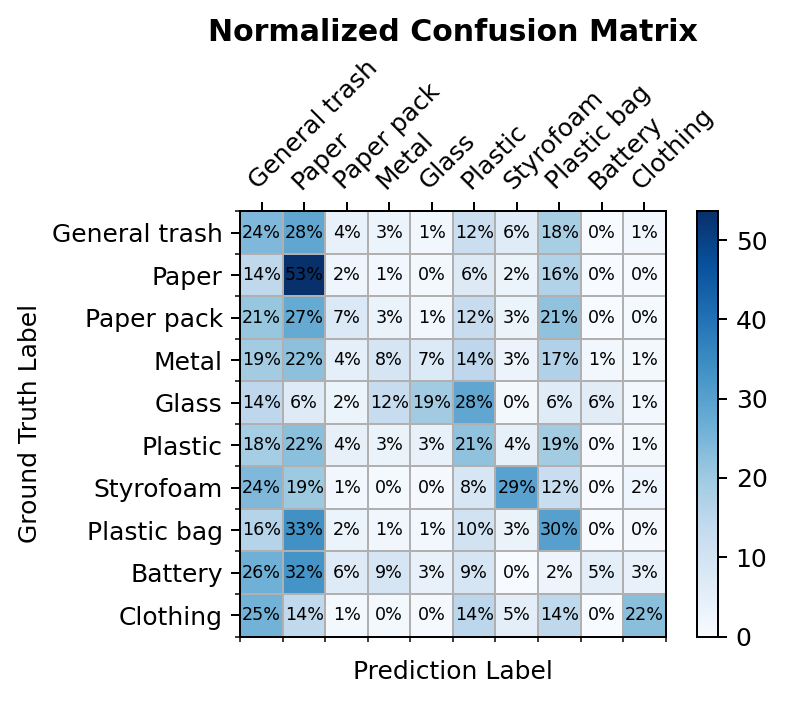

In [65]:
confusion_matrix = calculate_confusion_matrix(dataset, results,
                                              score_thr,
                                              nms_iou_thr,
                                              tp_iou_thr)

# Actual을 전부 더했을 때 100%가 안나올 수 있음(float형을 int형으로 바꾸면서 내림)
plot_confusion_matrix(
    confusion_matrix,
    dataset.CLASSES,
    save_dir=None,
    show=True,
    color_theme='Blues')